
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 敵対的生成ネットワーク

:ラベル: `sec_basic_gan`

この本のほとんどを通して、予測を行う方法について説明してきました。何らかの形で、私たちはディープ ニューラル ネットワークを使用して、データ例からラベルへのマッピングを学習しました。この種の学習は弁別学習と呼ばれます。たとえば、猫の写真と犬の写真を区別できるようにしたいと考えています。分類子と回帰子はどちらも識別学習の例です。そして、バックプロパゲーションによって訓練されたニューラル ネットワークは、大規模で複雑なデータセットでの識別学習について私たちが知っていると考えていたすべてを覆しました。高解像度画像の分類精度は、わずか 5 ～ 6 年で役に立たないレベルから人間レベルにまで向上しました (いくつかの注意点があります)。ディープ ニューラル ネットワークが驚くほどうまく機能する他のすべての識別タスクについては、これ以上ネタバレするのはやめておきます。

しかし、機械学習には、単に識別タスクを解決するだけではありません。たとえば、ラベルのない大規模なデータセットが与えられた場合、このデータの特性を簡潔に捉えるモデルを学習したい場合があります。このようなモデルがあれば、トレーニング データの分布に似た合成データの例をサンプリングできます。たとえば、顔写真の大規模なコーパスが与えられた場合、同じデータセットからのものであるかのように見える、新しいフォトリアリスティックな画像を生成できるようにしたいと思うかもしれません。この種の学習は生成モデリングと呼ばれます。

最近まで、新しいフォトリアリスティックな画像を合成できる方法はありませんでした。しかし、識別学習のためのディープ ニューラル ネットワークの成功により、新たな可能性が開かれました。過去 3 年間の大きなトレンドの 1 つは、一般に教師あり学習の問題とは考えられていない問題の課題を克服するために、識別ディープ ネットを適用することです。リカレント ニューラル ネットワーク言語モデルは、一度トレーニングすると生成モデルとして機能する判別ネットワーク (次の文字を予測するようにトレーニングされたもの) を使用する一例です。

 2014 年、画期的な論文で敵対的生成ネットワーク (GAN) :cite: `Goodfellow.Pouget-Abadie.Mirza.ea.2014`が紹介されました。これは、識別モデルの力を活用して優れた生成モデルを取得する賢い新しい方法です。 GAN は本質的に、偽のデータと本物のデータを区別できない場合にはデータ ジェネレーターが適切であるという考えに依存しています。統計学では、これは 2 標本検定と呼ばれます。これは、データセット $X={x_1,\ldots, x_n}$ と $X&#39;={x&#39;_1,\ldots, x&#39;_n}$ であるかどうかという質問に答えるための検定です。同じディストリビューションから抽出されました。ほとんどの統計論文と GAN の主な違いは、後者はこの考え方を建設的な方法で使用していることです。言い換えれば、単にモデルをトレーニングして「この 2 つのデータセットは同じ分布からのものではないようです」と言うのではなく、 [2 サンプル テストを](https://en.wikipedia.org/wiki/Two-sample_hypothesis_testing)使用して生成モデルにトレーニング信号を提供します。これにより、実際のデータに似たものを生成するまでデータ ジェネレーターを改善することができます。少なくとも、分類子が最先端のディープ ニューラル ネットワークであっても、分類子を騙す必要があります。

![](http://d2l.ai/_images/gan.svg) :ラベル: `fig_gan`

 GAN アーキテクチャは :numref: `fig_gan`に示されています。ご覧のとおり、GAN アーキテクチャには 2 つの部分があります。まず、次のようなデータを生成できる可能性のあるデバイス (ディープ ネットワークなどですが、実際にはゲーム レンダリング エンジンなど何でもあります) が必要です。本物と同じように。画像を扱う場合は、画像を生成する必要があります。音声を扱う場合は、オーディオ シーケンスなどを生成する必要があります。これをジェネレーターネットワークと呼びます。 2 番目のコンポーネントは弁別ネットワークです。偽のデータと本物のデータを区別しようとします。両方のネットワークが相互に競合しています。ジェネレーター ネットワークは、ディスクリミネーター ネットワークを騙そうとします。その時点で、弁別ネットワークは新しい偽データに適応します。この情報は、発電機ネットワークの改善などに使用されます。

 Discriminator は、入力 $x$ が本物 (実際のデータから) であるか偽物 (ジェネレーターから) であるかを区別するバイナリ分類子です。通常、弁別器は、隠れサイズ 1 の全結合層を使用するなど、入力 $\mathbf x$ に対してスカラー予測 $o\in\mathbb R$ を出力し、シグモイド関数を適用して予測確率 $D(\ mathbf x) = 1/(1+e^{-o})$。真のデータのラベル $y$ が $1$ であり、偽のデータのラベル $0$ であると仮定します。クロスエントロピー損失を最小限に抑える*ため*に弁別器を訓練します。

 $$ \min_D { - y \log D(\mathbf x) - (1-y)\log(1-D(\mathbf x)) },$$

ジェネレータの場合、まず、ランダム性のソース、*たとえば*正規分布 $\mathbf z \sim \mathcal{N} (0, 1)$ から何らかのパラメータ $\mathbf z\in\mathbb R^d$ を引き出します。 $\mathbf z$ を潜在変数と呼ぶことがよくあります。次に、関数を適用して $\mathbf x&#39;=G(\mathbf z)$ を生成します。ジェネレーターの目的は、判別器を騙して $\mathbf x&#39;=G(\mathbf z)$ を真のデータとして分類することです。*つまり*、$D( G(\mathbf z)) \およそ 1$ が必要です。言い換えれば、与えられた弁別器 $D$ に対して、$y=0$ の*とき*のクロスエントロピー損失を最大化するために生成器 $G$ のパラメータを更新します。

 $$ \max_G { - (1-y) \log(1-D(G(\mathbf z))) } = \max_G { - \log(1-D(G(\mathbf z))) }.$ $

ジェネレータが完璧な仕事をした場合、$D(\mathbf x&#39;)\ほぼ 1$ になるため、上記の損失は 0 に近くなり、その結果、勾配が小さすぎて弁別器がうまく処理できなくなります。したがって、一般的には次のような損失を最小限に抑えます。

 $$ \min_G { - y \log(D(G(\mathbf z))) } = \min_G { - \log(D(G(\mathbf z))) }, $$

これは $\mathbf x&#39;=G(\mathbf z)$ を弁別器に入力するだけですが、ラベル $y=1$ を与えます。

要約すると、$D$ と $G$ は、包括的な目的関数を使用した「ミニマックス」ゲームを行っています。

 $$\min_D \max_G { -E_{x \sim \text{データ}} \log D(\mathbf x) - E_{z \sim \text{ノイズ}} \log(1 - D(G(\mathbf z))) }.$$

 GAN アプリケーションの多くは画像のコンテキスト内にあります。デモンストレーションの目的として、最初ははるかに単純な分布を当てはめることに満足します。 GAN を使用して世界で最も非効率的なガウスのパラメータ推定器を構築すると何が起こるかを説明します。始めましょう。


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


## 「実際の」データを生成する

これは世界で最もひどい例になるため、単純にガウス分布から描画されたデータを生成します。


In [2]:
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b


何が得られたか見てみましょう。これは、平均 $b$ と共分散行列 $A^TA$ を使用して、かなり任意の方法でシフトされたガウス分布である必要があります。


The covariance matrix is
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


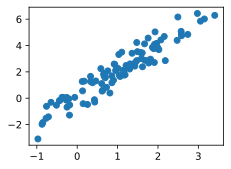

In [3]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, 0].detach().numpy(), data[:100, 1].detach().numpy());
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')

In [4]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)


## 発生器

私たちのジェネレーター ネットワークは、可能な限り最も単純なネットワーク、つまり単層線形モデルになります。これは、ガウス データ ジェネレーターを使用して線形ネットワークを駆動するためです。したがって、文字通り、完璧に偽装するためのパラメータを学習するだけで済みます。


In [5]:
net_G = nn.Sequential(nn.Linear(2, 2))


## ディスクリミネーター

弁別器については、もう少し弁別を強化します。物事をもう少し面白くするために、3 層の MLP を使用します。


In [6]:
net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1))


## トレーニング

まず、識別子を更新する関数を定義します。


In [7]:
#@save
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
              loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D


ジェネレーターも同様に更新されます。ここではクロスエントロピー損失を再利用しますが、偽データのラベルを $0$ から $1$ に変更します。


In [8]:
#@save
def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G


弁別器と生成器は両方とも、クロスエントロピー損失を使用してバイナリロジスティック回帰を実行します。トレーニング プロセスをスムーズにするために Adam を使用します。各反復では、まずディスクリミネーターを更新し、次にジェネレーターを更新します。損失と生成された例の両方を視覚化します。


In [9]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Visualize generated examples
        Z = torch.normal(0, 1, size=(100, latent_dim))
        fake_X = net_G(Z).detach().numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')


次に、ガウス分布に適合するハイパーパラメータを指定します。


loss_D 0.693, loss_G 0.693, 1177.1 examples/sec


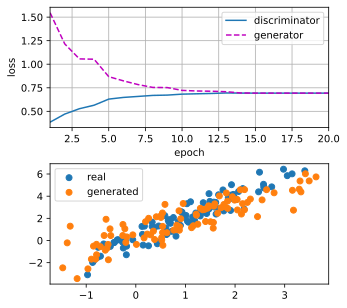

In [10]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
      latent_dim, data[:100].detach().numpy())


## まとめ
- 敵対的生成ネットワーク (GAN) は、ジェネレーターとディスクリミネーターという 2 つのディープ ネットワークで構成されます。
- ジェネレーターは、クロスエントロピー損失、*つまり*$\max \log(D(\mathbf{x&#39;}))$ を最大化することで、識別器を欺くために、できる限り真の画像に近い画像を生成します。
- 弁別器は、クロスエントロピー損失、*つまり*$\min - y \log D(\mathbf{x}) - (1-y)\log(1-D) を最小限に抑えることによって、生成された画像を真の画像から区別しようとします。 (\mathbf{x}))$。

## 演習
- ジェネレーターが勝つ場合、*つまり*ディスクリミネーターが有限サンプル上の 2 つの分布を区別できなくなるような平衡は存在しますか?



[ディスカッション](https://discuss.d2l.ai/t/1082)
